## The following code implements: SVM, NN, and LSTM Models on the UCI HAR Dataset

_Importing the necessary libraries_

In [1]:
import pandas as pd #used for data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np #used for linear algebra
from numpy import array
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
sns.set()

from collections import Counter

from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, Dropout,BatchNormalization
from keras.utils.np_utils import to_categorical

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf

import logging
tf.get_logger().setLevel(logging.ERROR)



In [2]:
training_data = pd.read_csv('Kaggle Dataset/train.csv')
testing_data = pd.read_csv('Kaggle Dataset/test.csv')

#Checking for null values
print("Training Data: {}".format(training_data.shape))
print("Null values present in training data: {}".format(training_data.isnull().values.any()))

print("Testing Data: {}".format(testing_data.shape))
print("Null values present in testing data: {}".format(testing_data.isnull().values.any()))


Training Data: (7352, 563)
Null values present in training data: False
Testing Data: (2947, 563)
Null values present in testing data: False


In [3]:
# Combine boths dataframes
training_data['Data'] = 'Train'
testing_data['Data'] = 'Test'
all_data = pd.concat([training_data, testing_data], axis=0).reset_index(drop=True)
all_data['subject'] = '#' + all_data['subject'].astype(str)

# Create label
label = all_data.pop('Activity')

pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in all_data.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


In [4]:
# Get X and y for training data
y_train = training_data['Activity']
X_train = training_data.drop(columns = ['Activity', 'subject'])

# Get X and y for testing data
y_test = testing_data['Activity']
X_test = testing_data.drop(columns = ['Activity', 'subject'])

In [5]:
y_train

0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
7347    WALKING_UPSTAIRS
7348    WALKING_UPSTAIRS
7349    WALKING_UPSTAIRS
7350    WALKING_UPSTAIRS
7351    WALKING_UPSTAIRS
Name: Activity, Length: 7352, dtype: object

In [6]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))



layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'),
                   height = 400,
                   width = 900)

fig = go.Figure(data=[data], layout=layout)
iplot(fig)


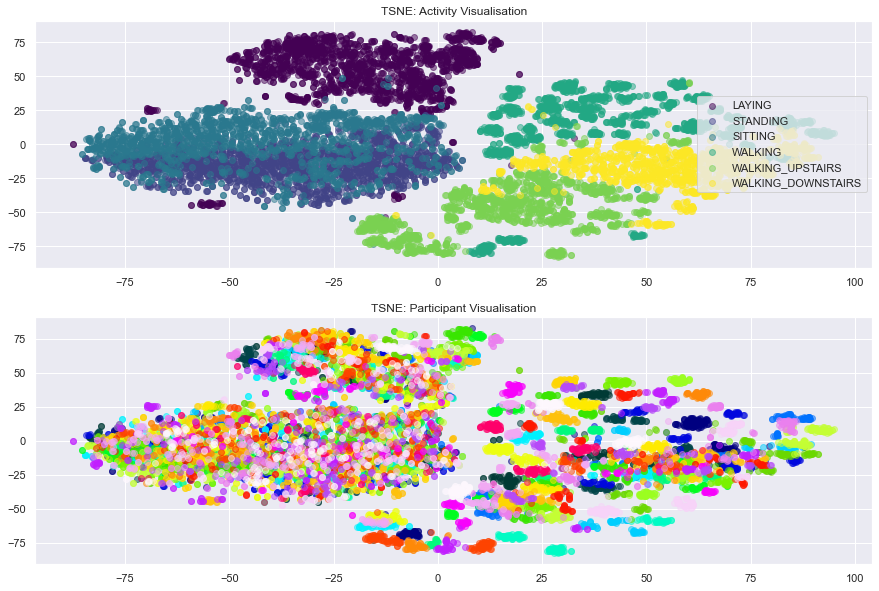

In [7]:
# Create datasets
tsne_data = all_data.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend(loc='center right', bbox_to_anchor=(1, 0.5))

### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
#axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [8]:
training_data = pd.read_csv('Kaggle Dataset/train.csv')
testing_data = pd.read_csv('Kaggle Dataset/test.csv')
target_names = ['Standing', 'Sitting', 'Laying','Walking','Walking DownStairs','Walking UpStairs']


# SVM

In [9]:
def define_models(models=dict()):
    # nonlinear models
    models['knn'] = KNeighborsClassifier(n_neighbors=7)
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    print('Defined %d models' % len(models))
    return models

# evaluate a single model
def evaluate_model(trainX, trainy, testX, testy, model):
    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    predictions = model.predict(testX)
    # evaluate predictions
    cm = confusion_matrix(testy, predictions)
    cr = classification_report(testy, predictions, target_names=target_names)
    accuracy = accuracy_score(testy, predictions)* 100.0
    precision = precision_score(testy,predictions,average='weighted')* 100.0
    recall = recall_score(testy, predictions,average='weighted')* 100.0

    return accuracy,precision,recall,cm,cr 

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(trainX, trainy, testX, testy, models):
    aaccuracy = dict()
    precision = dict()
    recall = dict()
    cm = dict()
    cr = dict()
    for name, model in models.items():
        # evaluate the model
        aaccuracy[name],precision[name],recall[name],cm[name],cr[name] = evaluate_model(trainX, trainy, testX, testy, model)
        # show process
    return aaccuracy,precision,recall,cm,cr

# print and plot the results
def summarize_results(results,precision,recall,cm,cr,maximize=True):
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,v) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    print()
    for name, score in mean_scores:
        print('Name: %s,\t Accuracy: %.3f,\t Precision: %.3f,\t Recall: %.3f\n' % (name, score,precision[name],recall[name]))
        
        print(cr[name])
        print()
        
        df_cm = pd.DataFrame(cm[name], index = target_names, columns = target_names)
        fig, ax = plt.subplots(figsize=(7,7))  
        heatmap = sns.heatmap(df_cm, annot=True, cmap='PuBu', ax= ax)
        heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45) 
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45) 
        plt.xlabel("Predicted", fontsize=13)
        plt.ylabel("True", fontsize=13)
        fig.suptitle(name, fontsize=20)
        plt.show()
        

In [10]:
def four_models(training_data, testing_data):
    # Get X and y for training data
    y_train = training_data['Activity']
    X_train = training_data.drop(columns = ['Activity', 'subject'])

    # Get X and y for testing data
    y_test = testing_data['Activity']
    X_test = testing_data.drop(columns = ['Activity', 'subject'])
    
    models = define_models()
    # evaluate models
    accuracy,precision,recall,cm,cr = evaluate_models(X_train, y_train, X_test, y_test, models)
    # summarize results
    summarize_results(accuracy,precision,recall,cm,cr)
    
    return accuracy
#FOUR_MODELS(training_data, testing_data)

Defined 3 models

Name: svm,	 Accuracy: 95.046,	 Precision: 95.129,	 Recall: 95.046

                    precision    recall  f1-score   support

          Standing       1.00      1.00      1.00       537
           Sitting       0.94      0.89      0.91       491
            Laying       0.91      0.95      0.93       532
           Walking       0.94      0.98      0.96       496
Walking DownStairs       0.99      0.91      0.95       420
  Walking UpStairs       0.93      0.96      0.94       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947




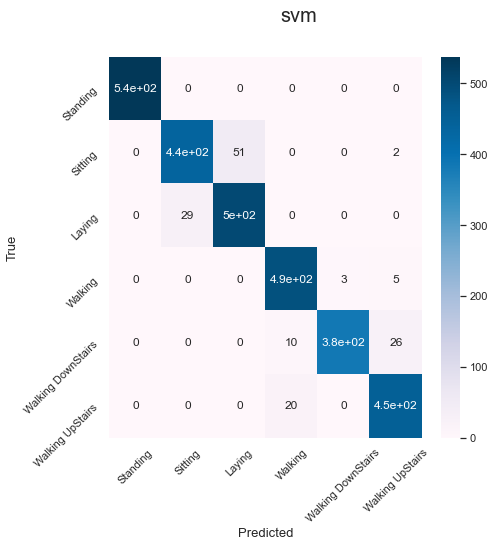

Name: knn,	 Accuracy: 90.227,	 Precision: 90.617,	 Recall: 90.227

                    precision    recall  f1-score   support

          Standing       1.00      0.99      1.00       537
           Sitting       0.91      0.80      0.85       491
            Laying       0.84      0.93      0.89       532
           Walking       0.84      0.97      0.90       496
Walking DownStairs       0.94      0.79      0.86       420
  Walking UpStairs       0.90      0.89      0.90       471

          accuracy                           0.90      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.90      0.90      2947




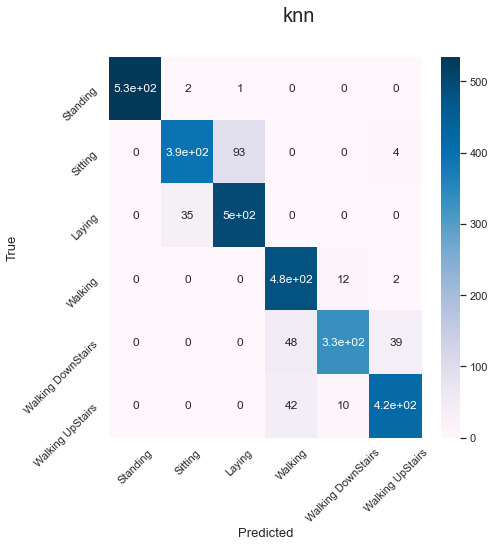

Name: bayes,	 Accuracy: 77.027,	 Precision: 79.468,	 Recall: 77.027

                    precision    recall  f1-score   support

          Standing       0.96      0.60      0.74       537
           Sitting       0.58      0.75      0.65       491
            Laying       0.80      0.86      0.83       532
           Walking       0.82      0.84      0.83       496
Walking DownStairs       0.83      0.61      0.70       420
  Walking UpStairs       0.76      0.96      0.84       471

          accuracy                           0.77      2947
         macro avg       0.79      0.77      0.77      2947
      weighted avg       0.79      0.77      0.77      2947




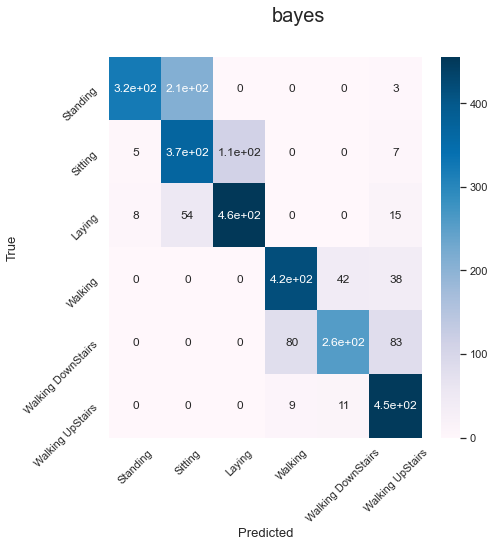

In [11]:
models_accuracy = four_models(training_data, testing_data)

# LSTM

In [12]:
#Training Data
X = training_data.iloc[:, 0:560].values
training_data['Activity']=training_data['Activity'].astype('category').cat.codes
y = training_data.iloc[:, 562].values
#y=y-1
y_train = keras.utils.to_categorical(y)

#Testing Data
XT = testing_data.iloc[:, 0:560].values
testing_data['Activity']=testing_data['Activity'].astype('category').cat.codes
yT = testing_data.iloc[:, 562].values
y_test = keras.utils.to_categorical(yT)

In [13]:
sc = StandardScaler()
x_train = sc.fit_transform(X)
x_test = sc.fit_transform(XT)

In [14]:
x_test = x_test.reshape(2947,1,560)
x_train = x_train.reshape(7352,1,560)

In [15]:
model = Sequential()

model.add(LSTM(128,input_shape=(x_train.shape[1:]), activation = 'relu',return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(64,input_shape=(x_train.shape[1:]),activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(6,activation = 'softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [16]:
model.fit(x_train, y_train, epochs = 20, batch_size=128)

Epoch 1/20
58/58 [==============================] - 3s 8ms/step - loss: 1.0963 - accuracy: 0.5925: 0s - loss: 1.3818 - accuracy
Epoch 2/20
58/58 [==============================] - 0s 5ms/step - loss: 0.2554 - accuracy: 0.9230
Epoch 3/20
58/58 [==============================] - 0s 5ms/step - loss: 0.1584 - accuracy: 0.9505
Epoch 4/20
58/58 [==============================] - 0s 5ms/step - loss: 0.1073 - accuracy: 0.9692
Epoch 5/20
58/58 [==============================] - 0s 5ms/step - loss: 0.0907 - accuracy: 0.9724
Epoch 6/20
58/58 [==============================] - 0s 5ms/step - loss: 0.0795 - accuracy: 0.9764
Epoch 7/20
58/58 [==============================] - 0s 5ms/step - loss: 0.0692 - accuracy: 0.9745
Epoch 8/20
58/58 [==============================] - 0s 5ms/step - loss: 0.0536 - accuracy: 0.9818
Epoch 9/20
58/58 [==============================] - 0s 5ms/step - loss: 0.0582 - accuracy: 0.9826
Epoch 10/20
58/58 [==============================] - 0s 5ms/step - loss: 0.0446 - accura

In [17]:
score = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)

93/93 [==============================] - 0s 875us/step - loss: 0.1609 - accuracy: 0.9535


In [18]:
y_pred_LSTM = (y_pred > 0.5)
print('LSTM: {}%'.format(accuracy_score(y_test, y_pred_LSTM)*100))
predictionLSTM = round((accuracy_score(y_test, y_pred_LSTM)*100),4)
print(predictionLSTM)

LSTM: 95.31727180183238%
95.3173


In [19]:
y_pred_LSTM = (y_pred > 0.5)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred_LSTM,axis=1)

print(classification_report(y_test_class,y_pred_class, target_names=target_names))
print(confusion_matrix(y_test_class,y_pred_class))

                    precision    recall  f1-score   support

          Standing       0.99      1.00      0.99       537
           Sitting       0.94      0.93      0.94       491
            Laying       0.94      0.95      0.95       532
           Walking       0.93      0.98      0.95       496
Walking DownStairs       0.97      0.91      0.94       420
  Walking UpStairs       0.94      0.93      0.94       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947

[[537   0   0   0   0   0]
 [  1 459  30   0   0   1]
 [  0  28 504   0   0   0]
 [  0   0   0 488   8   0]
 [  1   0   0  11 383  25]
 [  4   0   0  27   2 438]]


In [21]:
models = [("SVM",models_accuracy['svm']),("KNN",models_accuracy['knn']),
          ("Bayes",models_accuracy['bayes']),("LSTM",predictionLSTM)]
for i in models:
    print("{}".format(i[0]), "\t\t {}%".format(round(i[1],2)))
max = 0.0
min = 100.0
best =""
worst = ""
for i in models:
    value = i[1]
    if i[1]> max :
        best = i[0]
        max = i[1]
    if i[1]<min :
        worst = i[0]
        min = i[1]
print("--------------------------")        
print("Best Model: \t",best)
print("Worst Model:\t",worst)
print("--------------------------")   

SVM 		 95.05%
KNN 		 90.23%
Bayes 		 77.03%
LSTM 		 95.32%
--------------------------
Best Model: 	 LSTM
Worst Model:	 Bayes
--------------------------
